In [1]:
import sys
import os
current_dir = os.getcwd()  
project_root = os.path.dirname(current_dir)  
sys.path.insert(0, project_root) 
import numpy as np
import pandas as pd
from pycaret.regression import load_model, predict_model
from src.config.config import Config
from src.data.data_loader import DataLoader
from src.features.feature_engineering import FeatureEngineering
from src.visualization.visualizer import Visualizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict_test_set(test_data: pd.DataFrame, model_path: str):
    """预测测试集结果并返回评估指标

    Args:
        test_data: 测试数据集
        model_path: 模型文件路径
        test_type: 测试类型，'country' 或 'time'

    Returns:
        dict: 包含预测结果和评估指标的字典
    """
    target_column = Config.DATA_CONFIG['target_column']
    method = Config.FEATURE_CONFIG['target_transform_method']
    transformed_column = f'{target_column}_{method}'
    target_column_pred = f'{target_column}_pred'

    # 加载模型
    model = load_model(model_path)
    
    # 预测
    predictions = predict_model(model, data=test_data)

    # 处理预测结果
    test_results = test_data.copy()
    test_results[target_column_pred] = np.expm1(predictions['prediction_label'])
    test_results[target_column] = np.expm1(test_results[transformed_column])
    test_results['prediction_label'] = predictions['prediction_label']

    # 新增原始值误差指标（用于业务解释）
    raw_errors = test_results[target_column_pred] - test_results[target_column]
    test_results['Abs_Percent_Error'] = (raw_errors / test_results[target_column]).abs() * 100
    
    # 计算对数空间误差
    y_true_log = test_results[transformed_column]
    y_pred_log = predictions['prediction_label']
    
    # 计算原始空间误差
    y_true = test_results[target_column]
    y_pred = test_results[target_column_pred]

    # 计算指标
    metrics = {
        # 对数空间
        'MAE_log': mean_absolute_error(y_true_log, y_pred_log),
        'RMSE_log': np.sqrt(mean_squared_error(y_true_log, y_pred_log)),
        'R2_log': r2_score(y_true_log, y_pred_log),
        
        # 原始空间
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(test_results['Abs_Percent_Error']),
        'Median_APE': np.median(test_results['Abs_Percent_Error'])
    }
    
    print("\n模型评估指标:")
    print("【对数空间】")
    print(f"MAE: {metrics['MAE_log']:.4f}  RMSE: {metrics['RMSE_log']:.4f}  R²: {metrics['R2_log']:.4f}")
    print("\n【原始空间】")
    print(f"MAE: {metrics['MAE']:,.2f}  RMSE: {metrics['RMSE']:,.2f}  R²: {metrics['R2']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%  Median APE: {metrics['Median_APE']:.2f}%")

    return test_results

In [2]:
# 加载数据
data_loader = DataLoader(Config.DATA_CONFIG['data_path'])
feature_engineering = FeatureEngineering()

# 加载训练集和测试集
train_data = pd.read_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'train.csv'))
country_test_data = pd.read_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'test.csv'))
time_test_data = pd.read_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'time_test_data.csv'))

# 模型路径
model_path = os.path.join(Config.PATH_CONFIG['models_dir'], 'blend_250321_175001')

# Predict country test set
print('\nCountry test set predictions:')
country_results = predict_test_set(country_test_data, model_path)

# Predict time test set
print('\nTime test set predictions:')
time_results = predict_test_set(time_test_data, model_path)

visualizer = Visualizer()


Country test set predictions:
Transformation Pipeline and Model Successfully Loaded

模型评估指标:
【对数空间】
MAE: 0.0191  RMSE: 0.0259  R²: 0.9996

【原始空间】
MAE: 887,765.47  RMSE: 2,059,255.16  R²: 0.9992
MAPE: 1.90%  Median APE: 1.40%

Time test set predictions:
Transformation Pipeline and Model Successfully Loaded

模型评估指标:
【对数空间】
MAE: 0.1176  RMSE: 0.1648  R²: 0.9877

【原始空间】
MAE: 3,017,850.82  RMSE: 8,700,424.38  R²: 0.9394
MAPE: 12.02%  Median APE: 7.91%


In [3]:
# Print available countries
countries = sorted(country_results['Country Name'].unique())
print('\nCountry Available countries:')
for i, country in enumerate(countries, 1):
    print(f'{i}. {country}')

# Print available countries
countries = sorted(time_results['Country Name'].unique())
print('\nTime Available countries:')
for i, country in enumerate(countries, 1):
    print(f'{i}. {country}')


Country Available countries:
1. Algeria
2. Australia
3. Egypt, Arab Rep.
4. Finland
5. France
6. Germany
7. India
8. Pakistan
9. Portugal
10. Thailand
11. Ukraine
12. United States

Time Available countries:
1. Albania
2. Argentina
3. Austria
4. Bangladesh
5. Belgium
6. Bosnia and Herzegovina
7. Brazil
8. Bulgaria
9. Canada
10. China
11. Colombia
12. Congo, Dem. Rep.
13. Croatia
14. Cyprus
15. Czechia
16. Denmark
17. Estonia
18. Ethiopia
19. Greece
20. Hungary
21. Iceland
22. Indonesia
23. Iran, Islamic Rep.
24. Iraq
25. Ireland
26. Italy
27. Japan
28. Korea, Rep.
29. Latvia
30. Lithuania
31. Luxembourg
32. Malaysia
33. Malta
34. Mexico
35. Montenegro
36. Morocco
37. Netherlands
38. Nigeria
39. North Macedonia
40. Norway
41. Peru
42. Philippines
43. Poland
44. Romania
45. Russian Federation
46. Saudi Arabia
47. Serbia
48. Slovak Republic
49. Slovenia
50. South Africa
51. Spain
52. Sweden
53. Switzerland
54. Tanzania
55. Turkiye
56. Uganda
57. United Kingdom


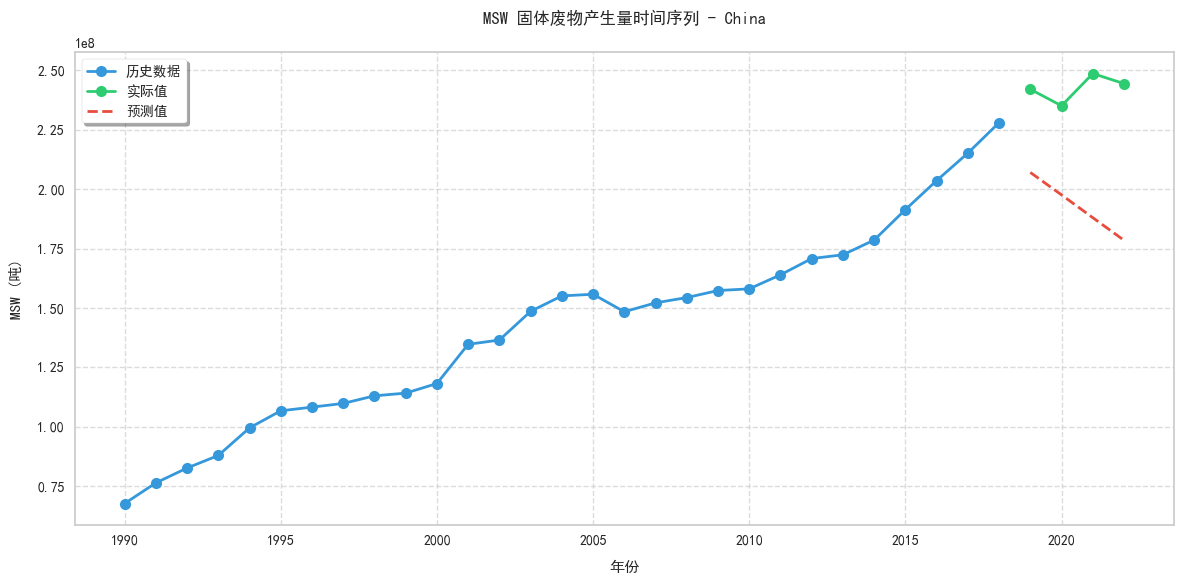

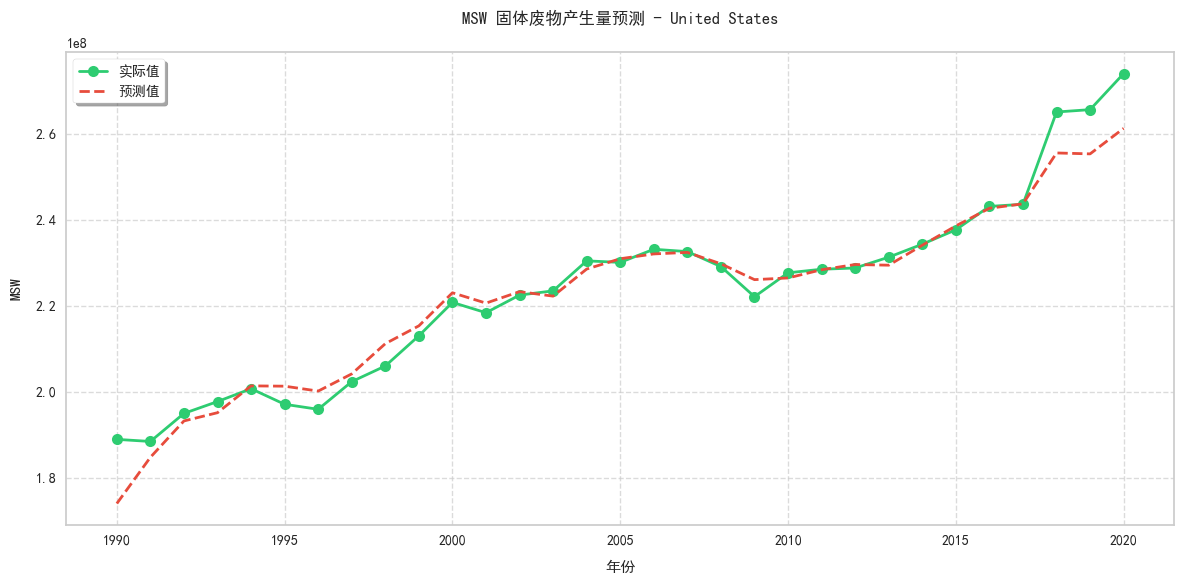

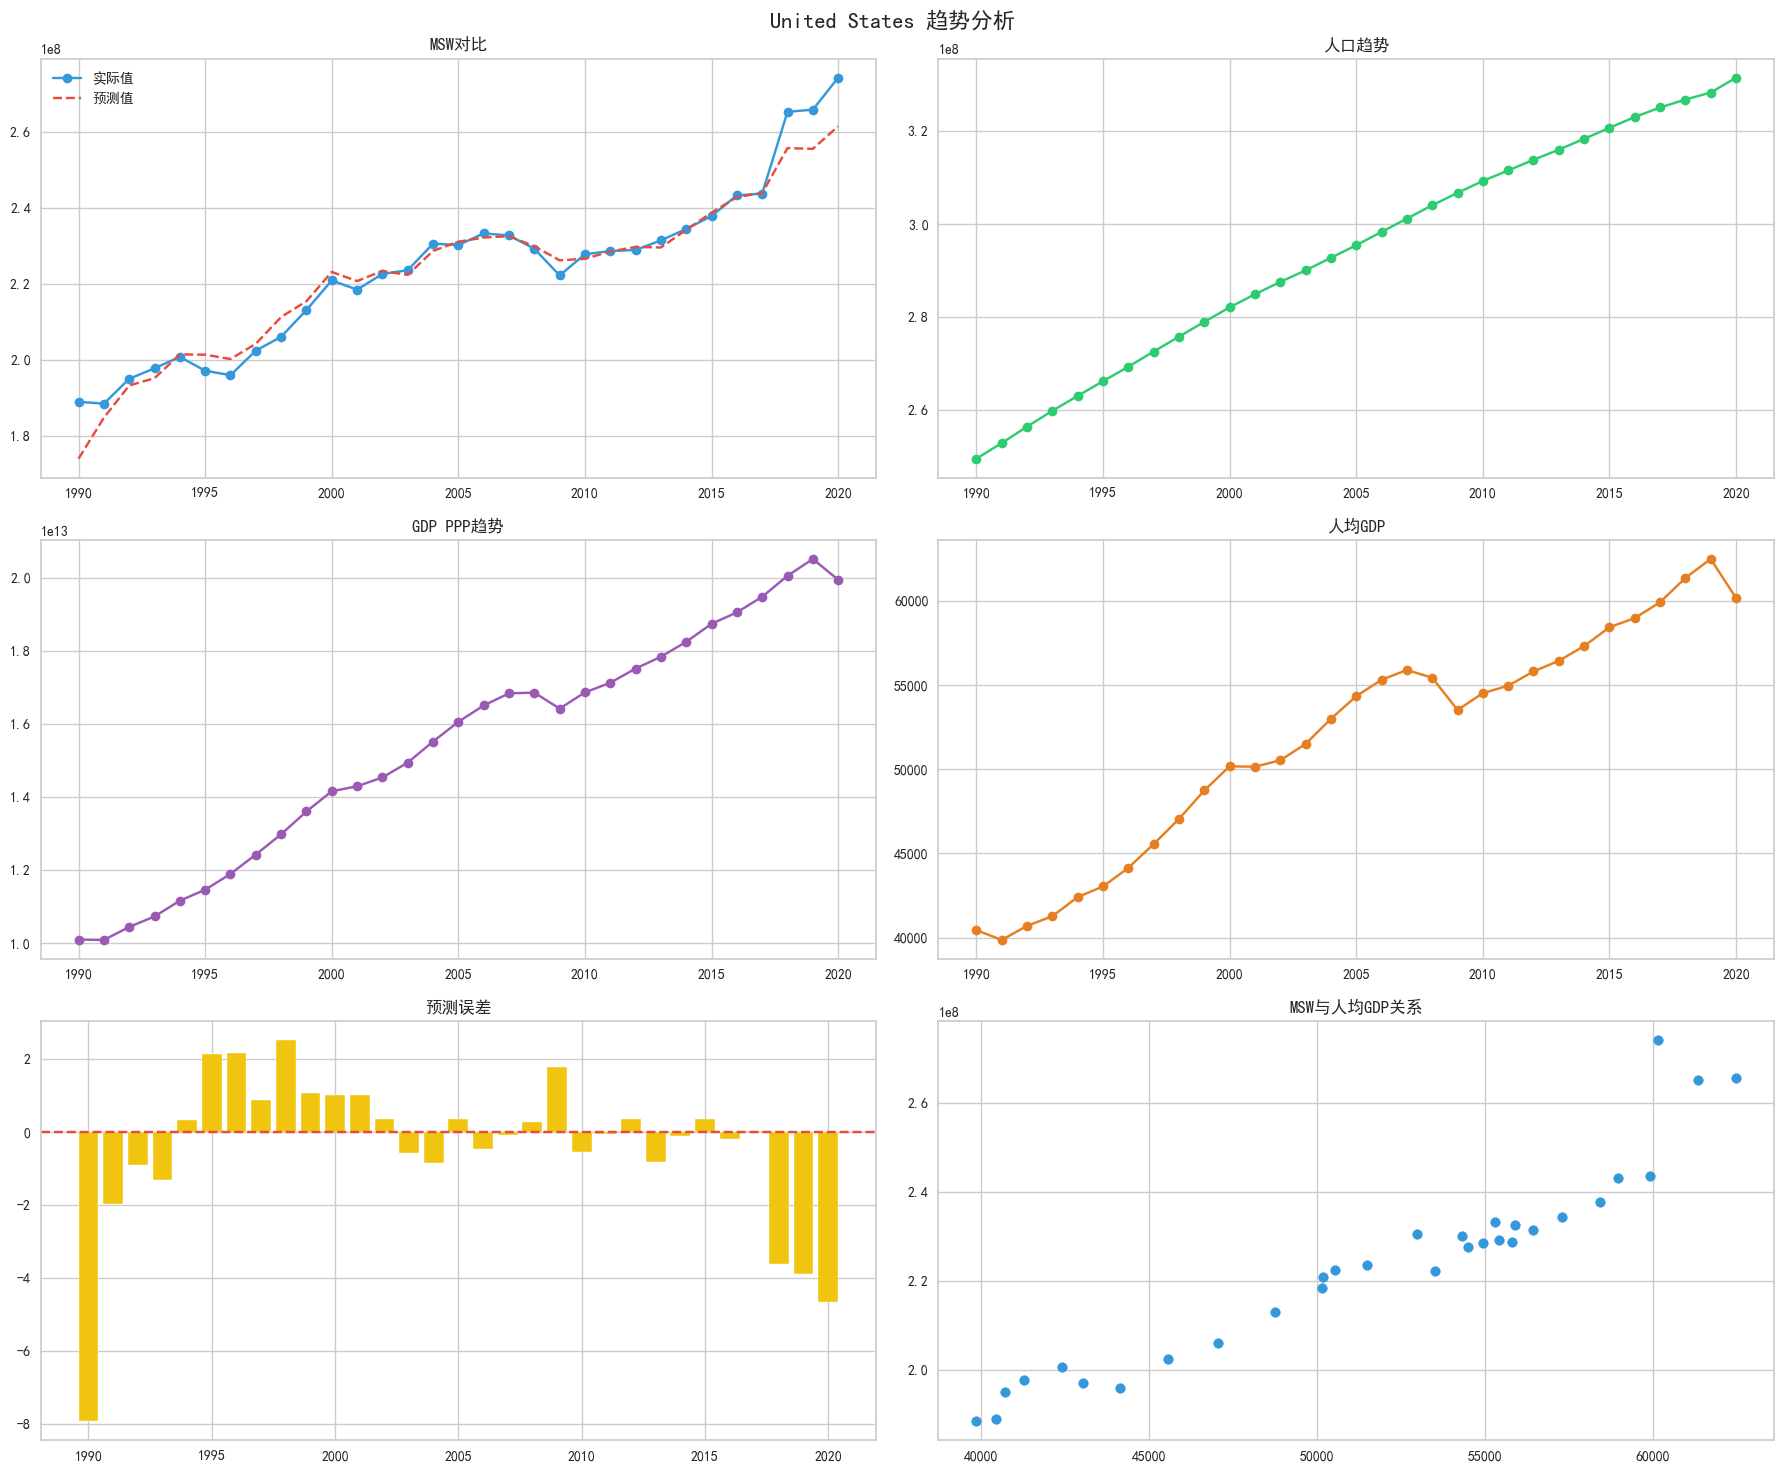

In [4]:
country = 'China'
train = train_data[train_data['Country Name'] == country].sort_values('Year')
test = time_results[time_results['Country Name'] == country].sort_values('Year')
visualizer.plot_time_predictions(country, train, test)

country = 'United States'
test = country_results[country_results['Country Name'] == country].sort_values('Year')
visualizer.plot_country_predictions(country,test)
visualizer.plot_country_multiple_metrics(country,test)

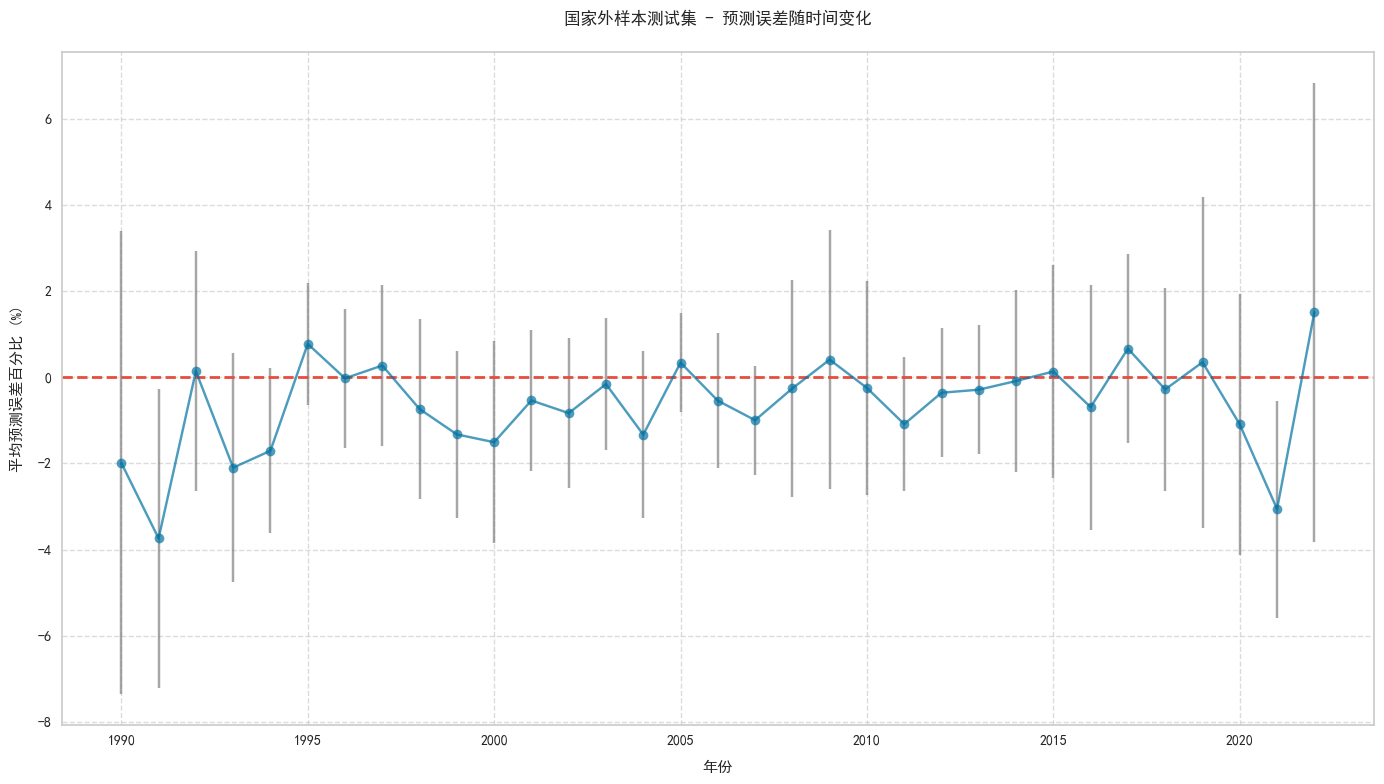

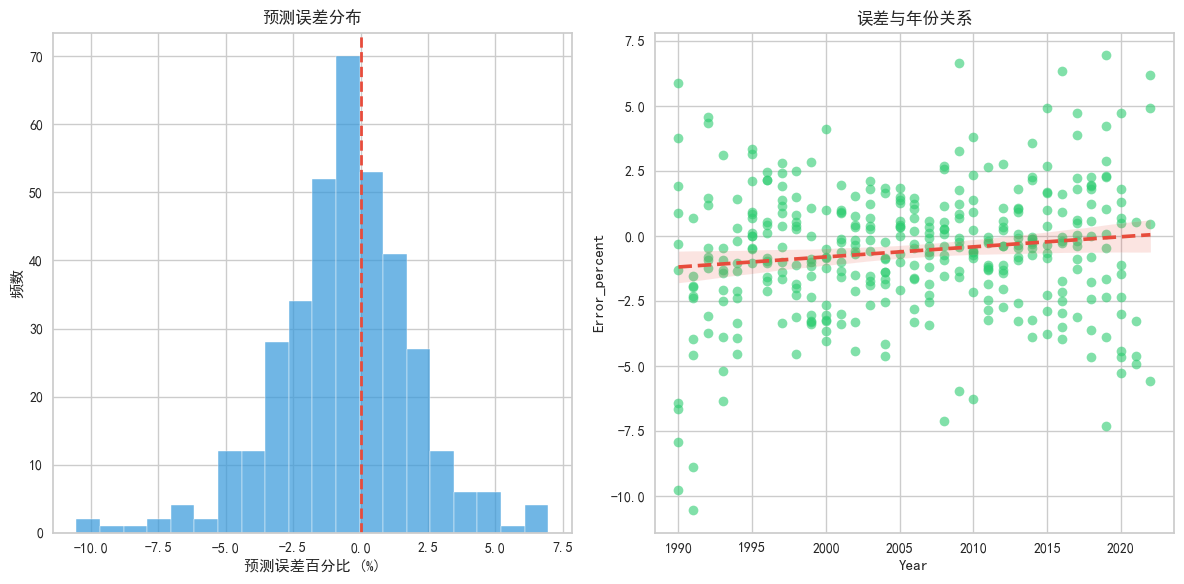

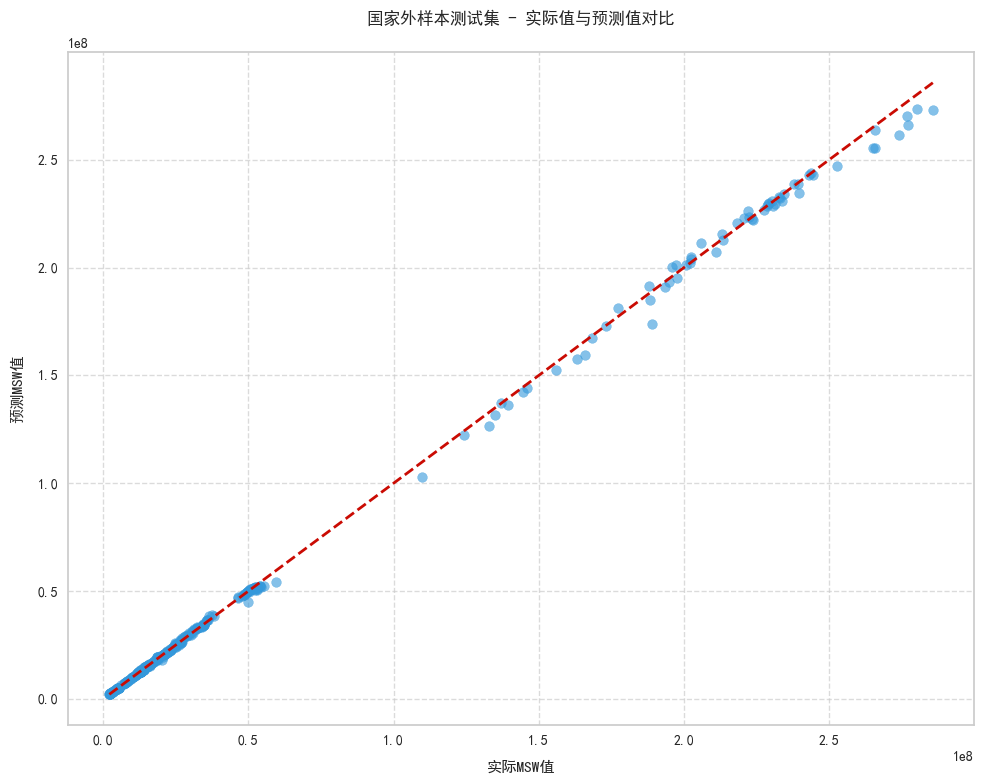

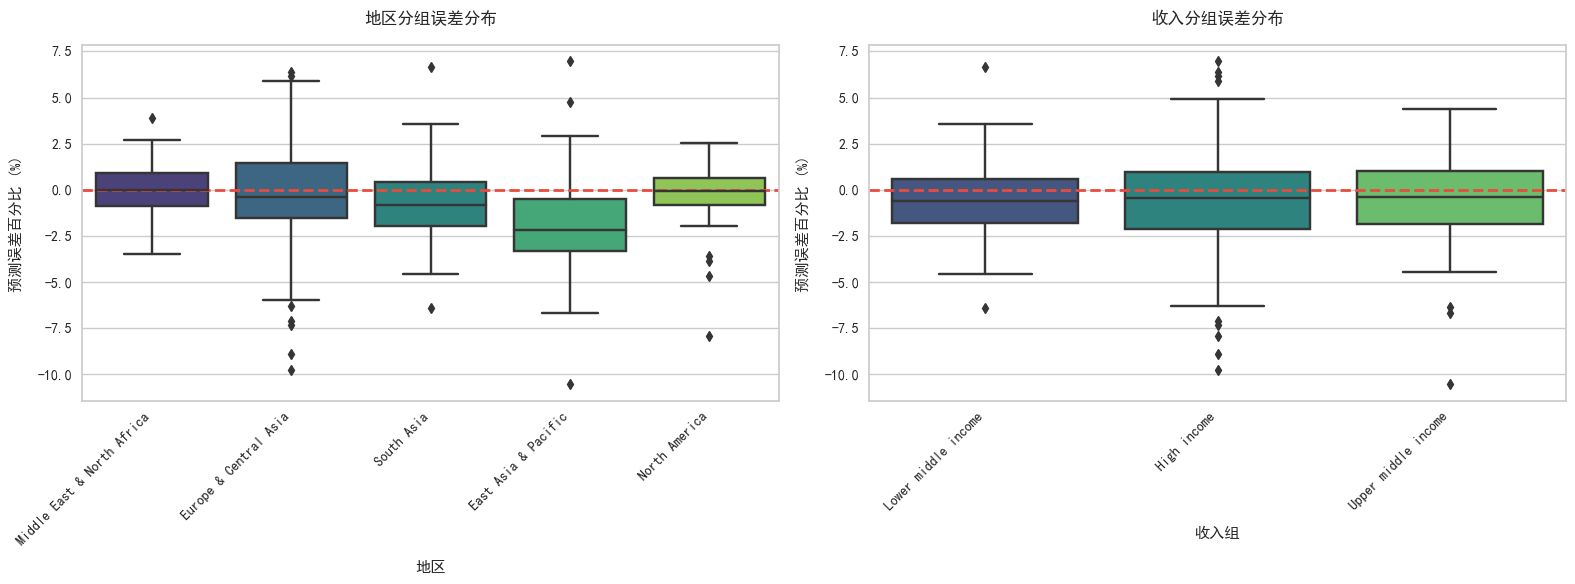

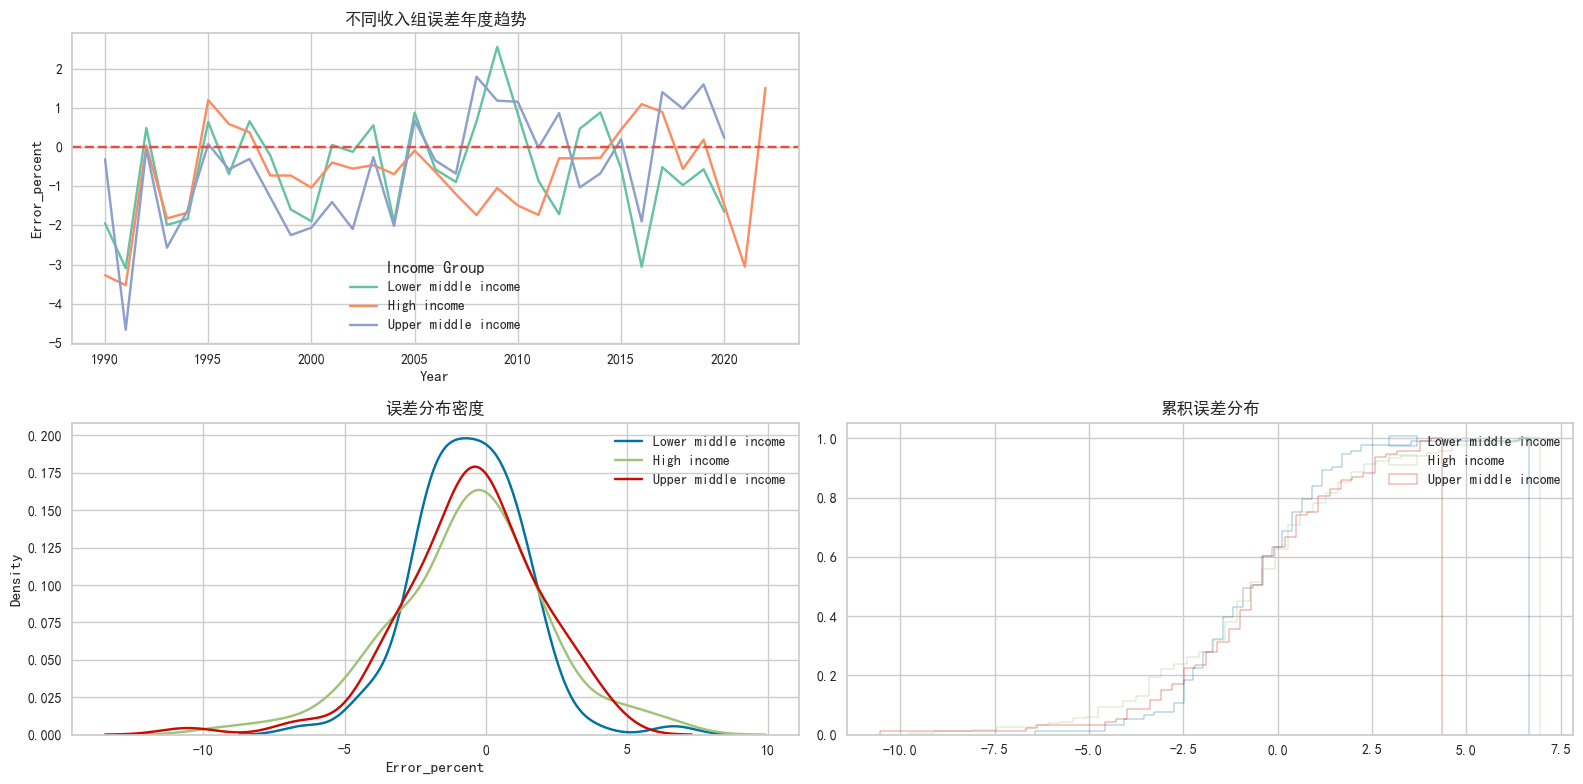

In [5]:
visualizer.plot_overall_performance(country_results)

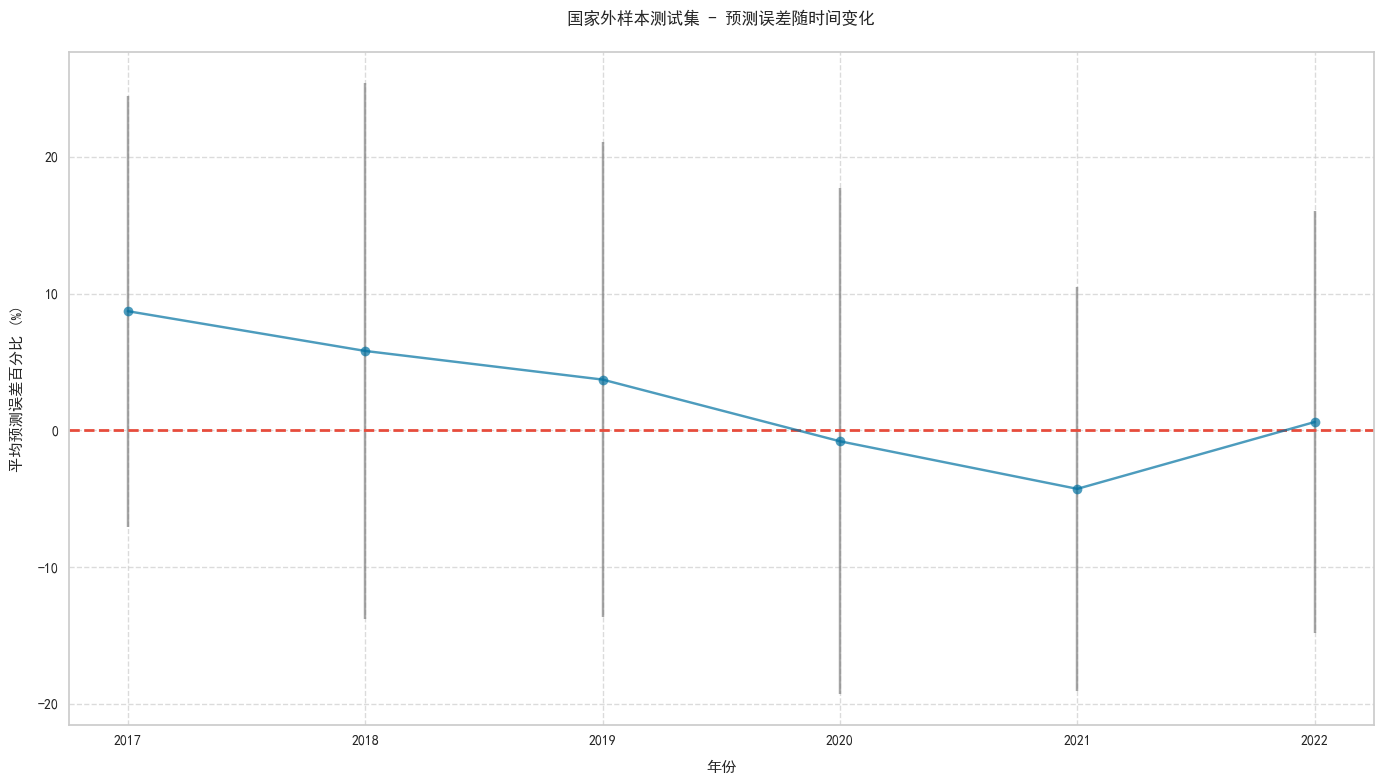

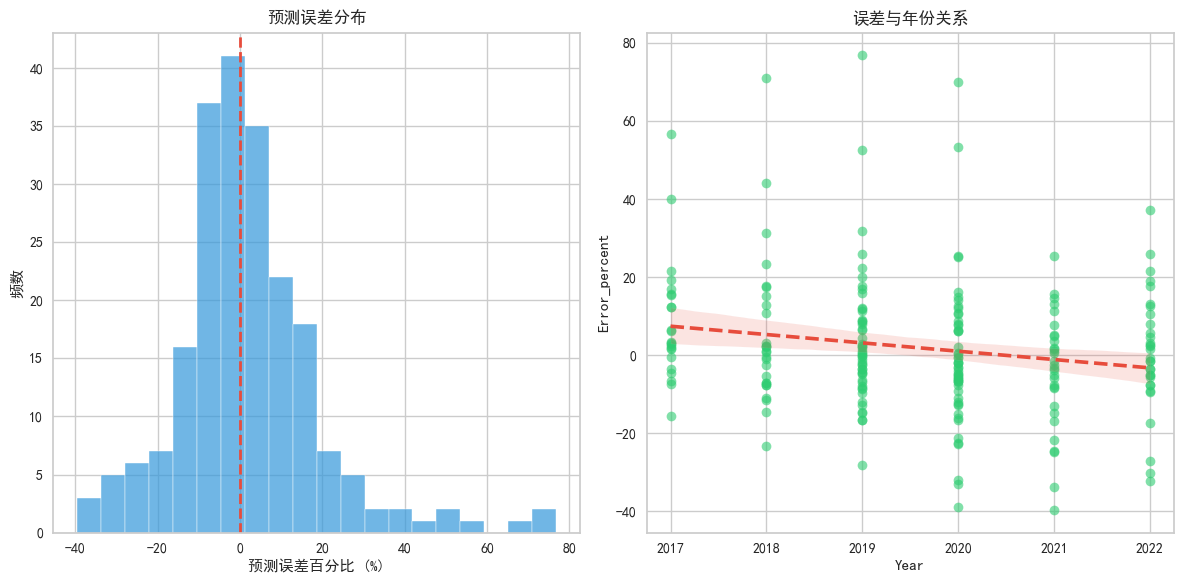

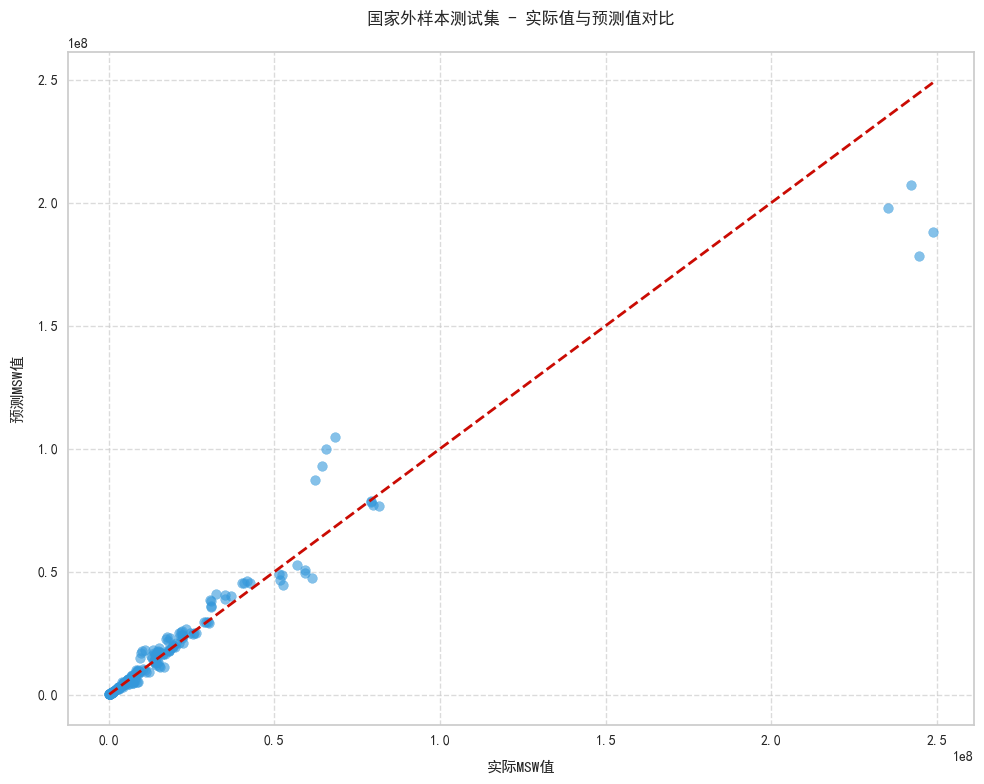

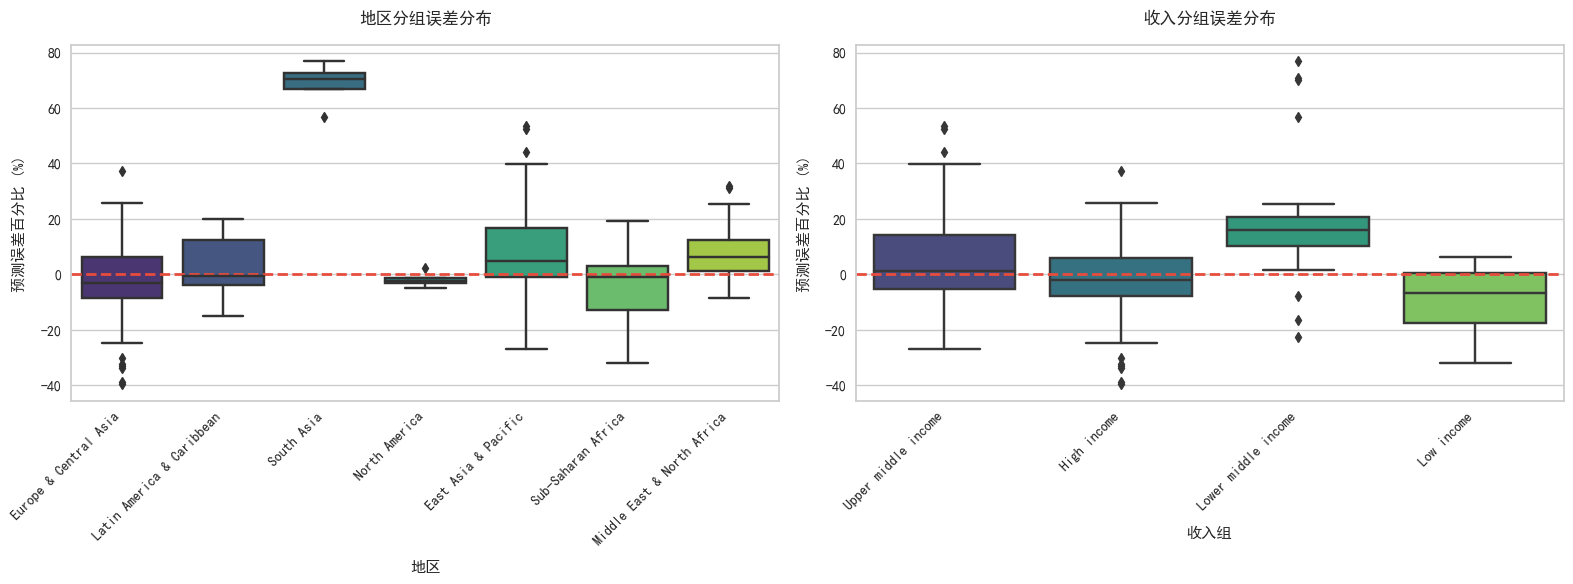

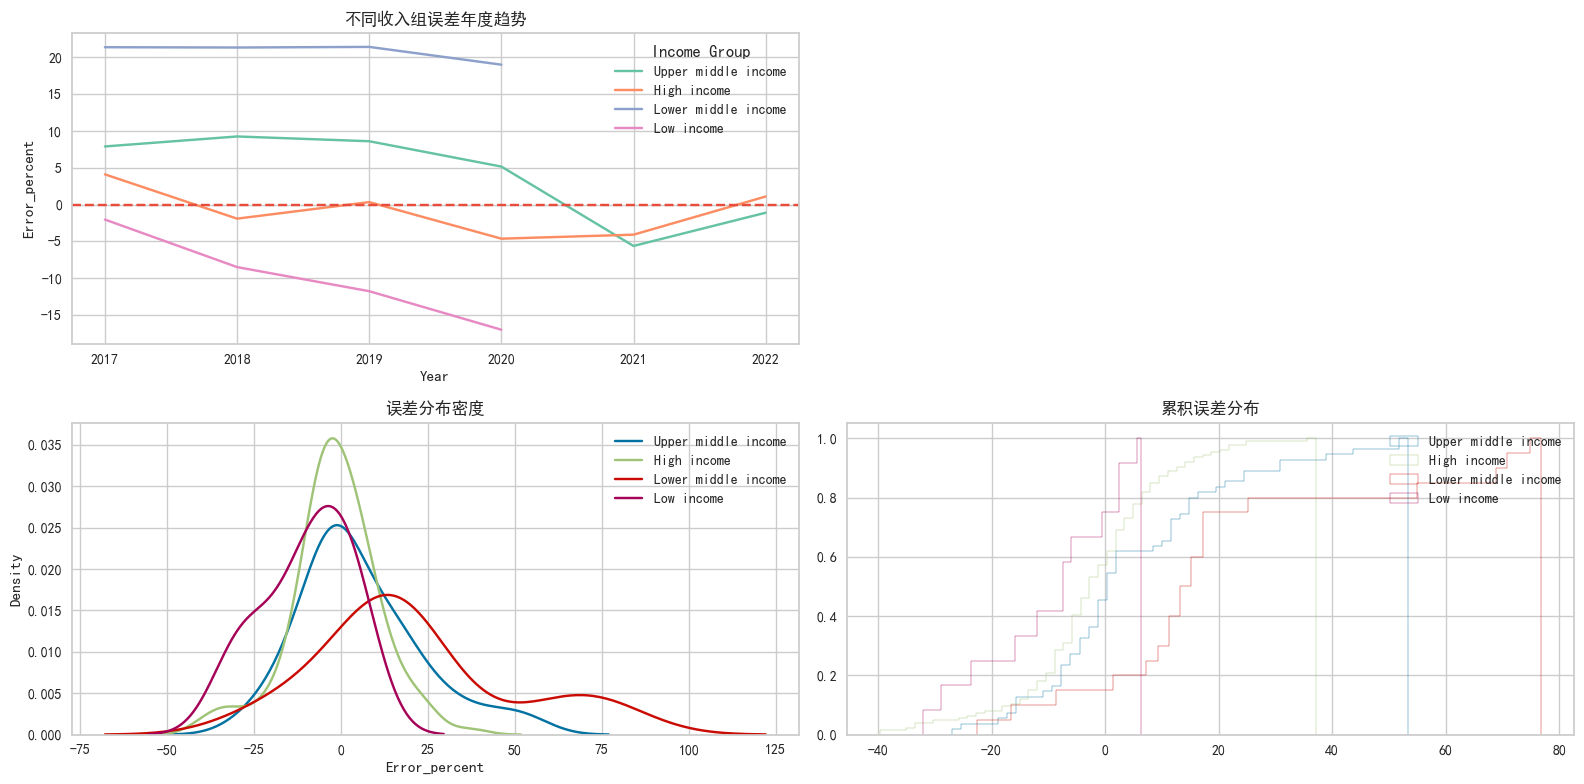

In [6]:
visualizer.plot_overall_performance(time_results)

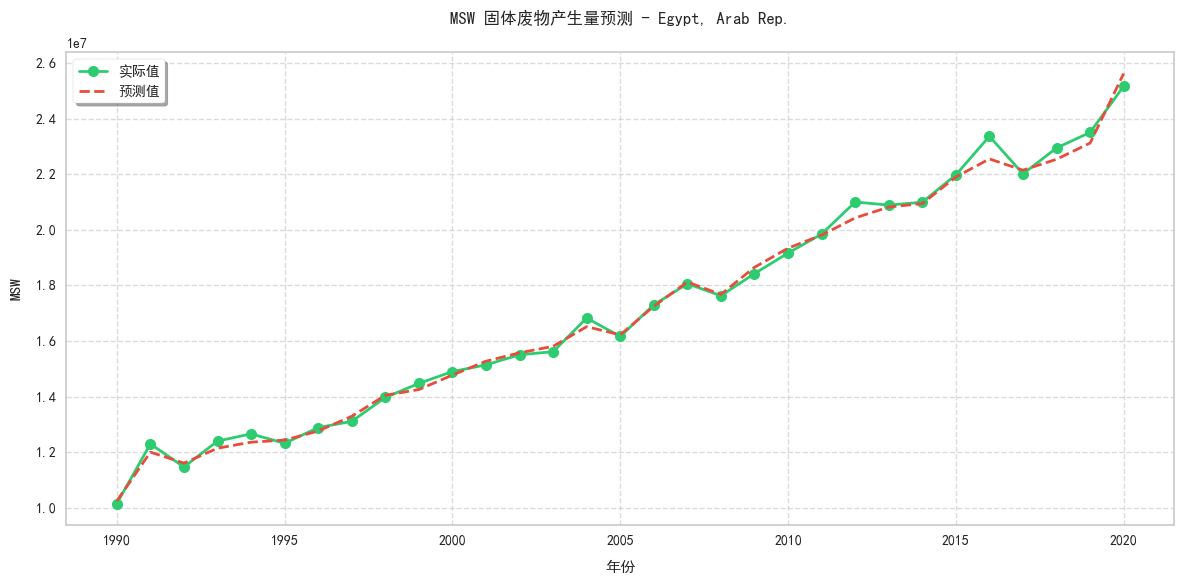

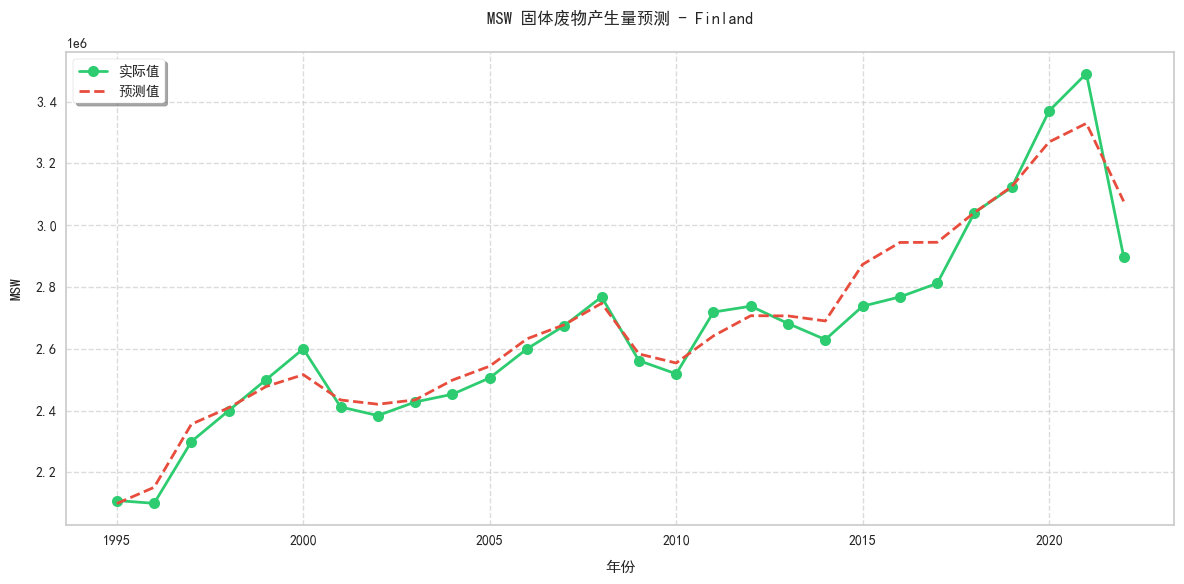

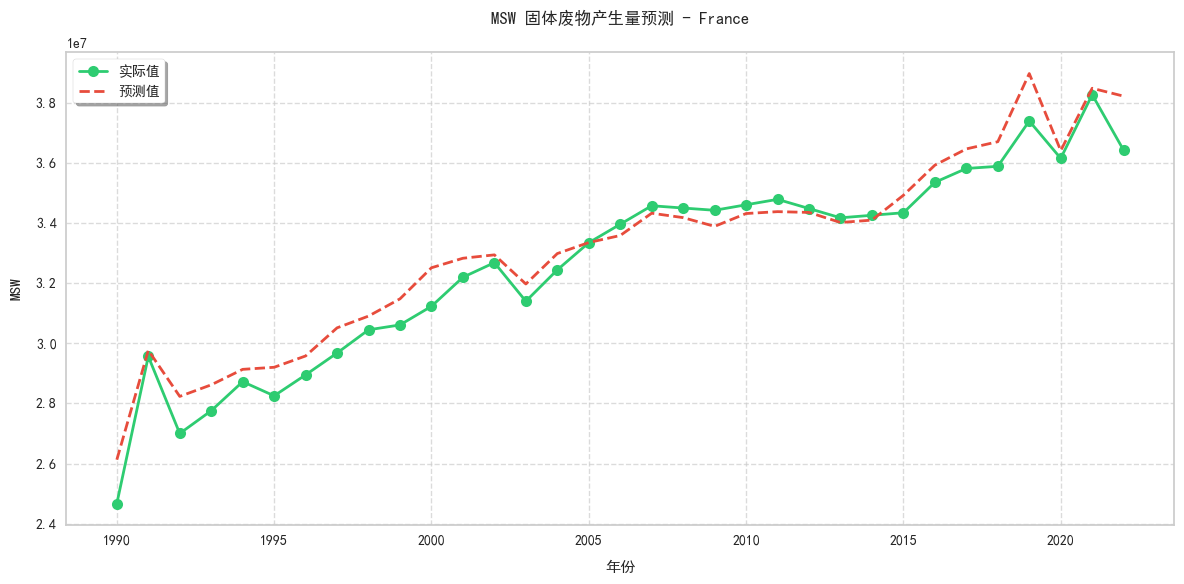

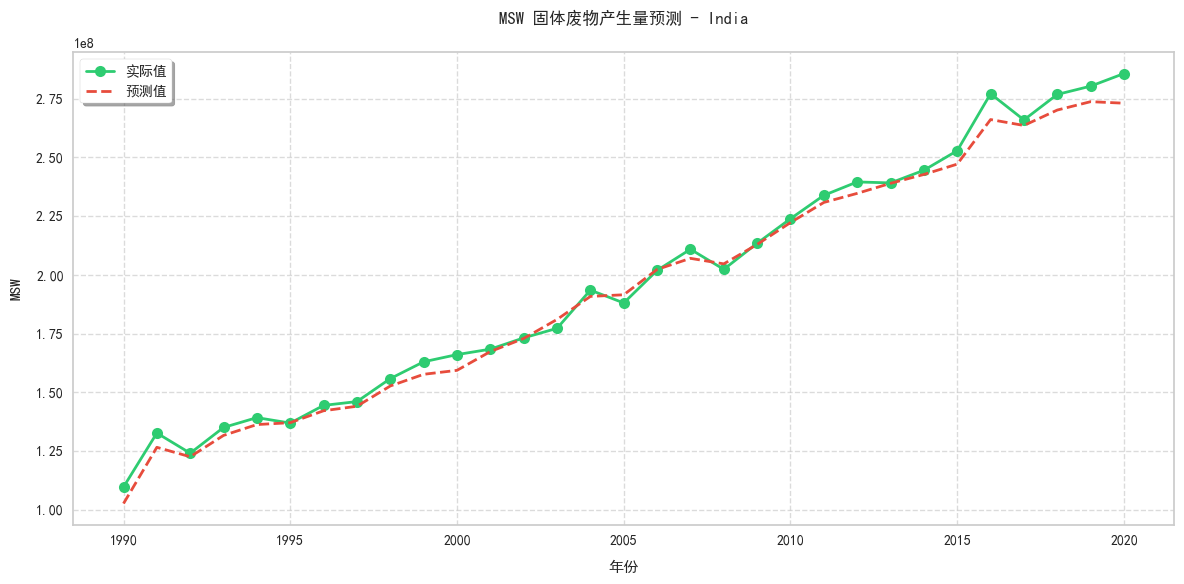

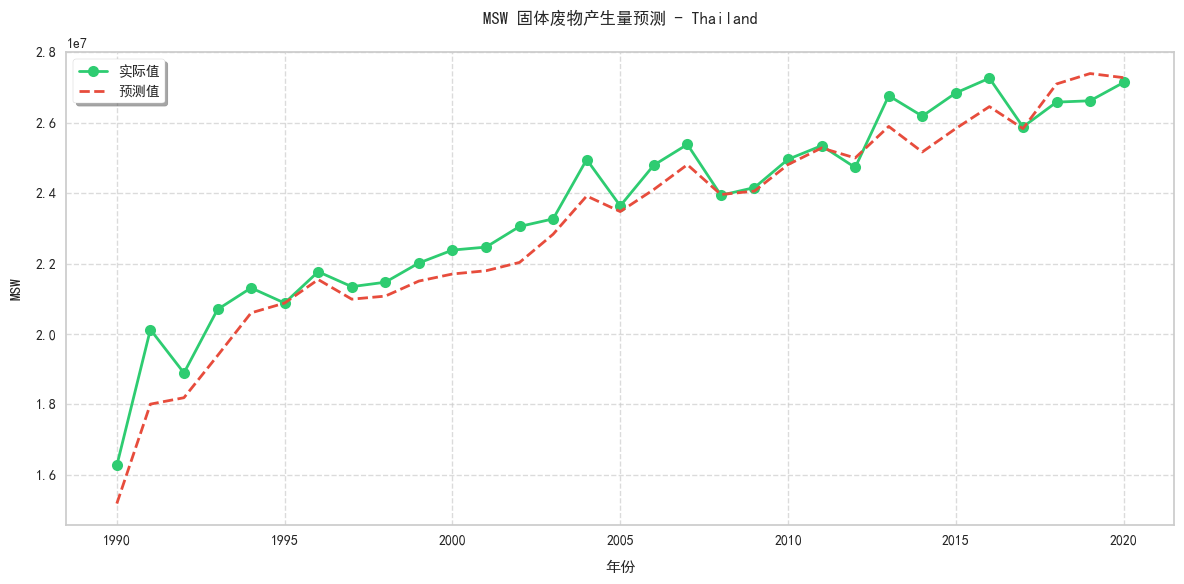

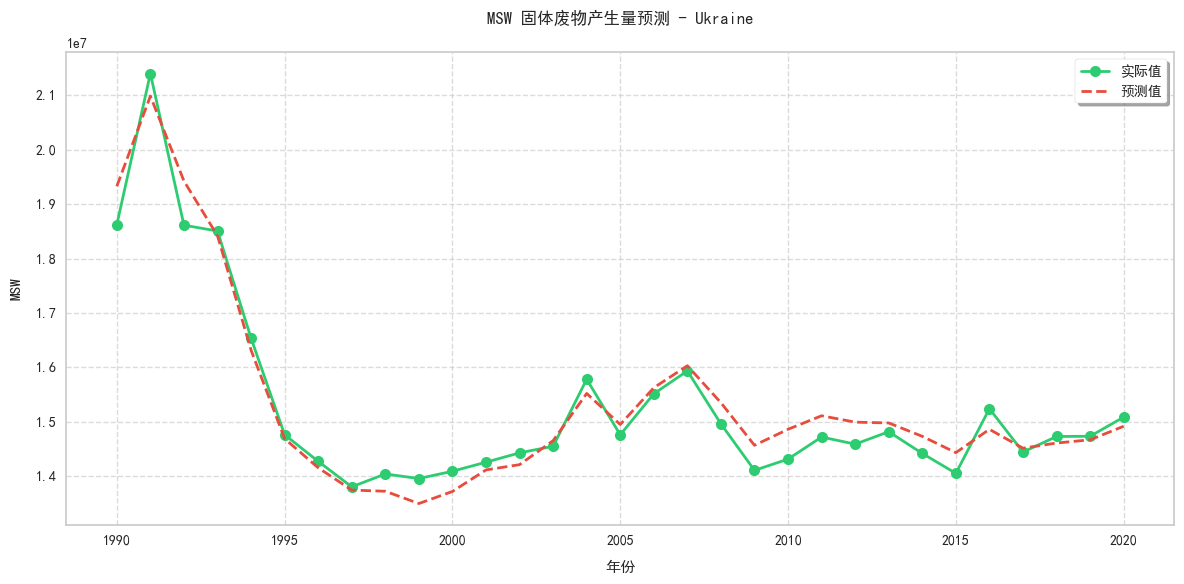

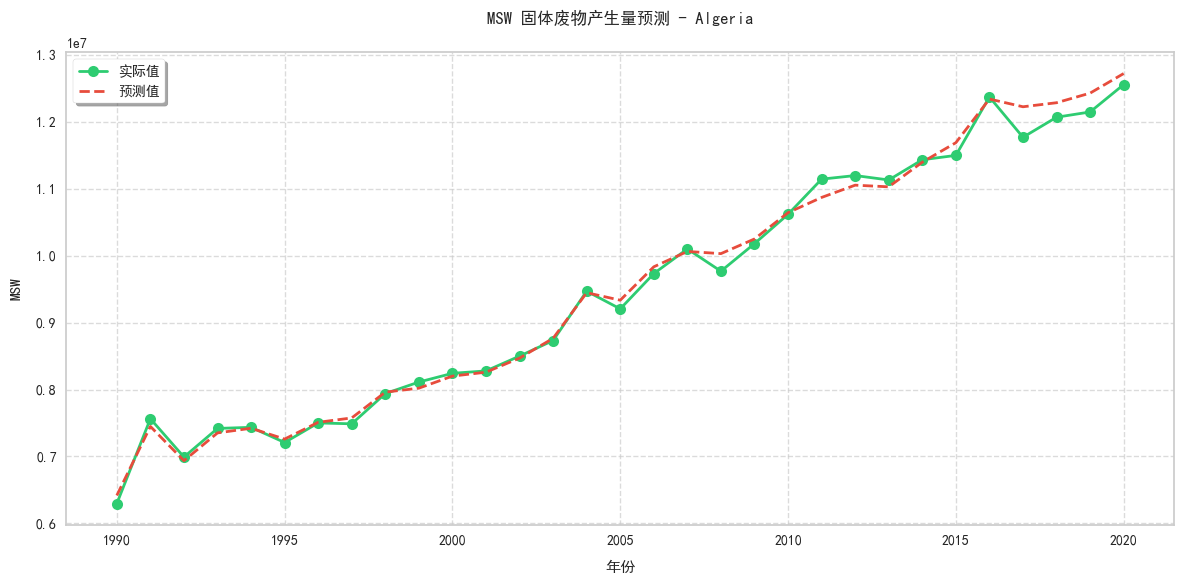

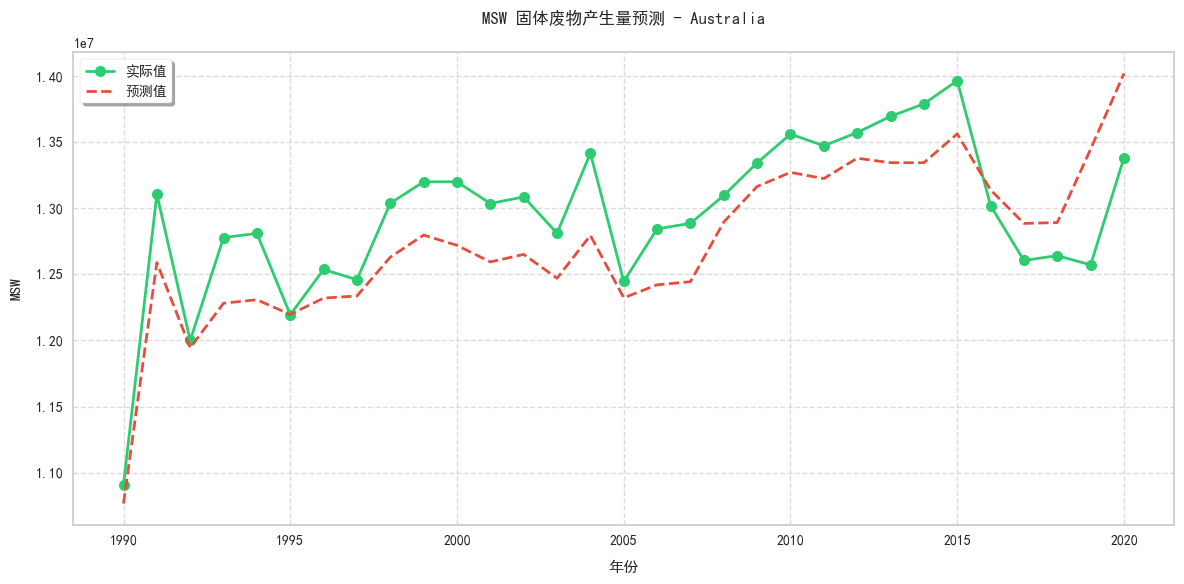

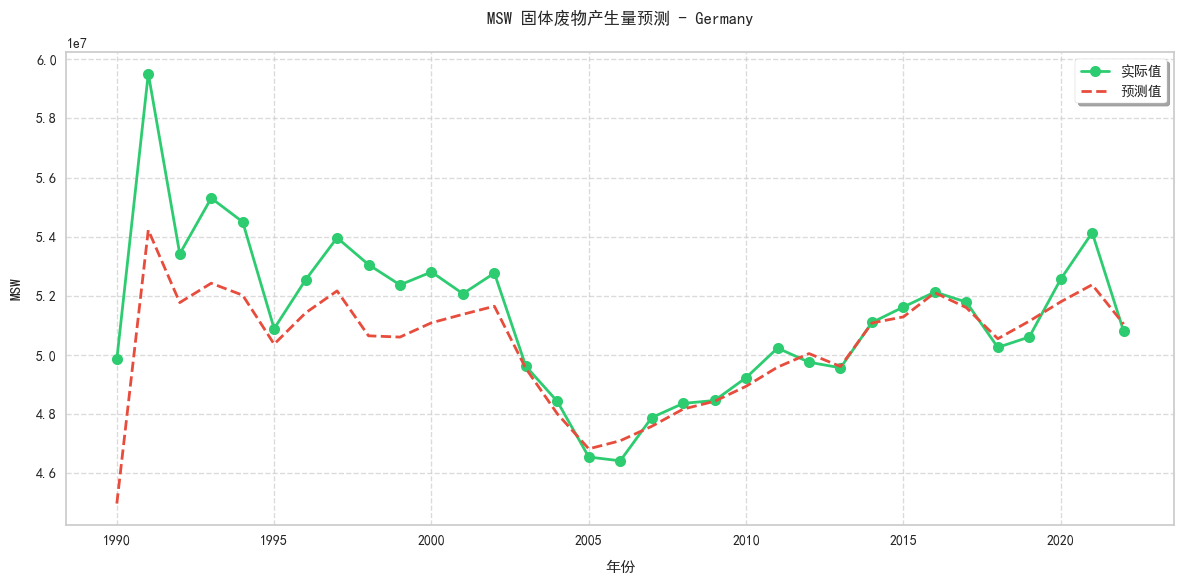

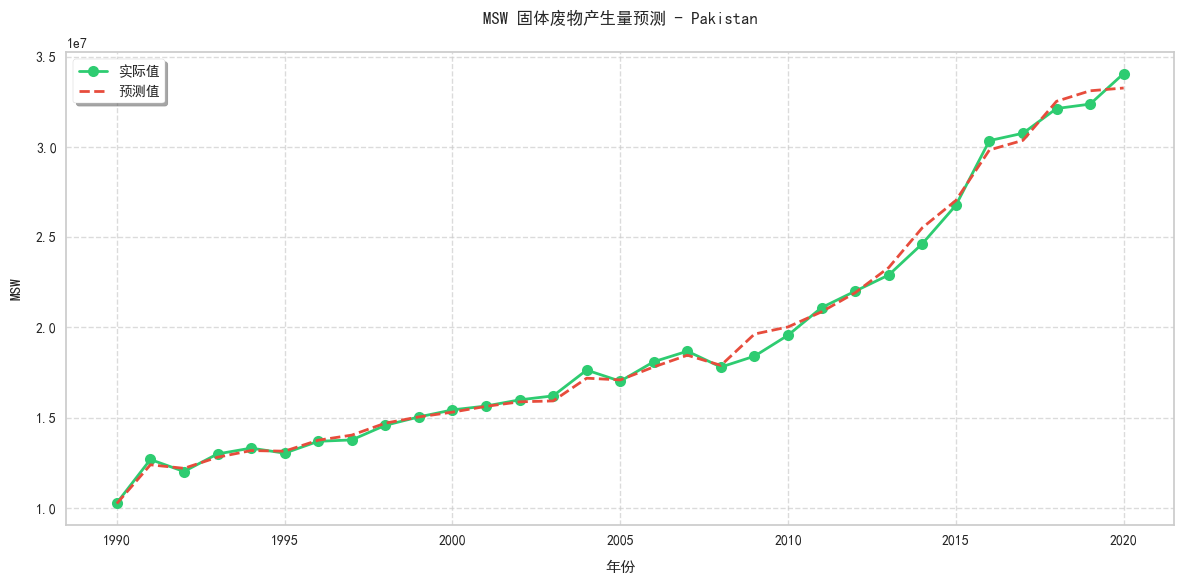

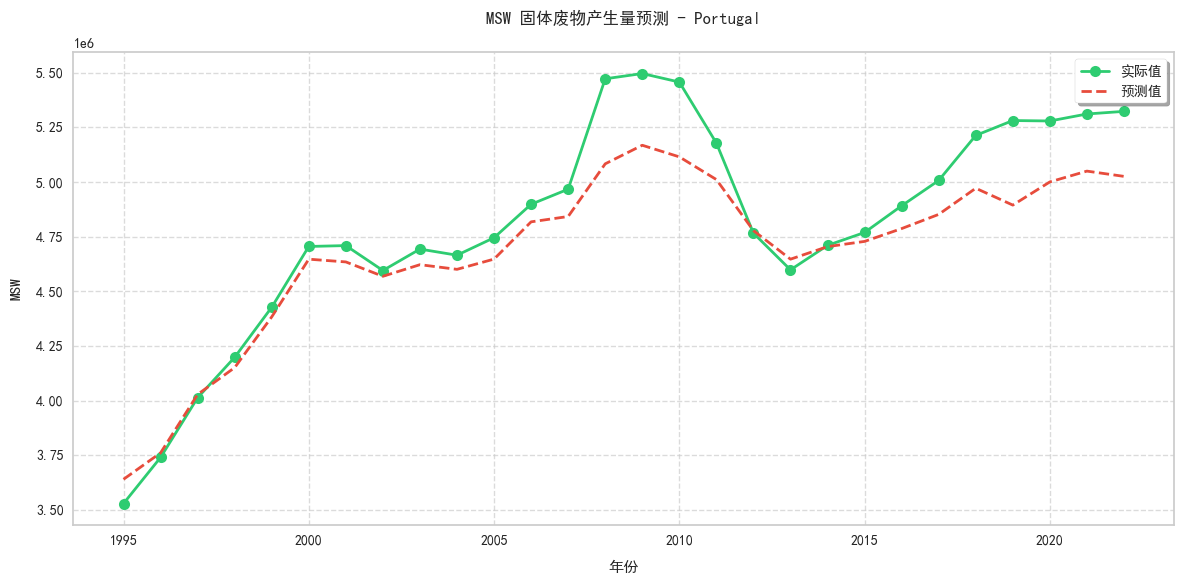

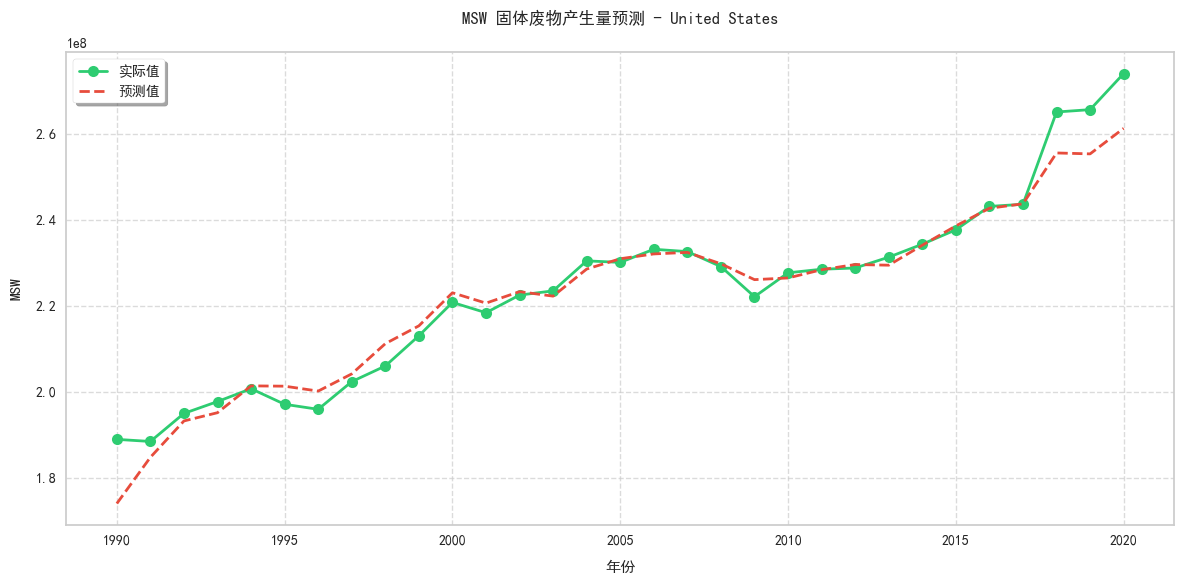

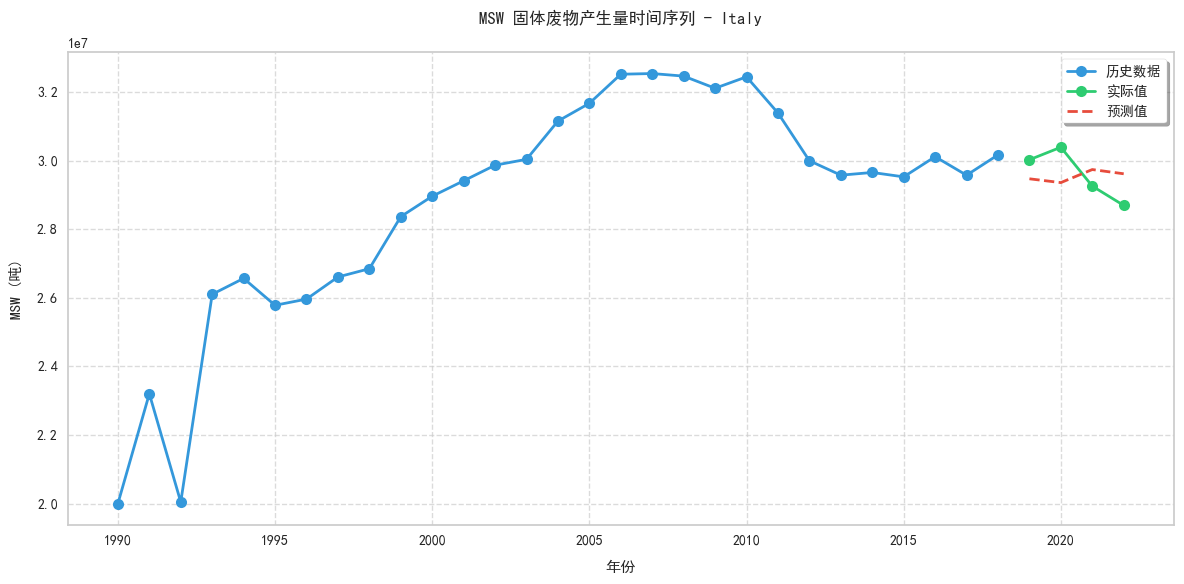

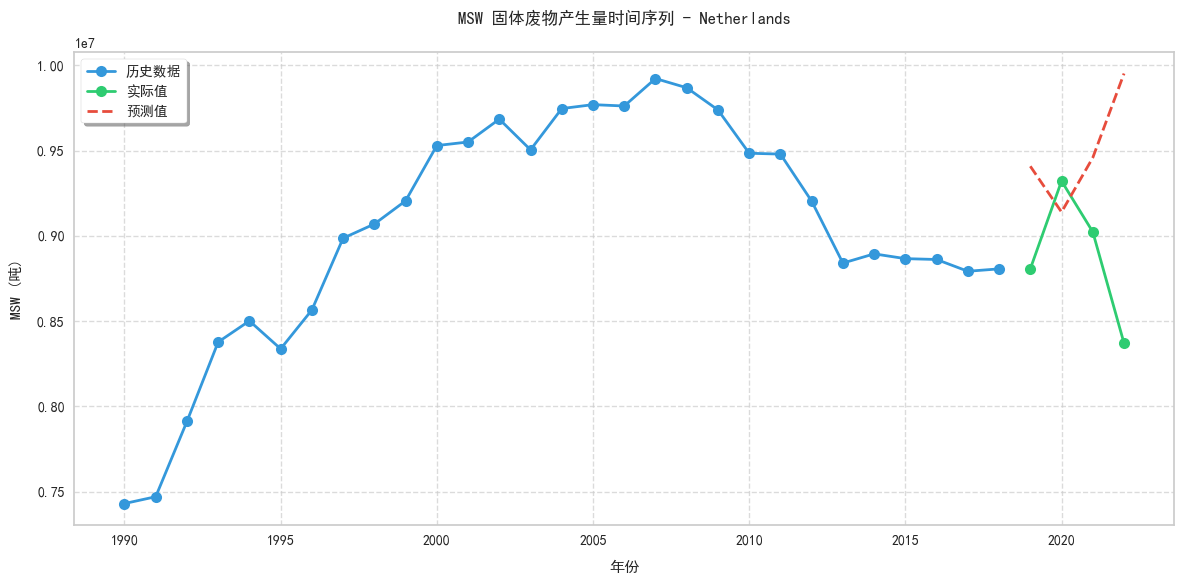

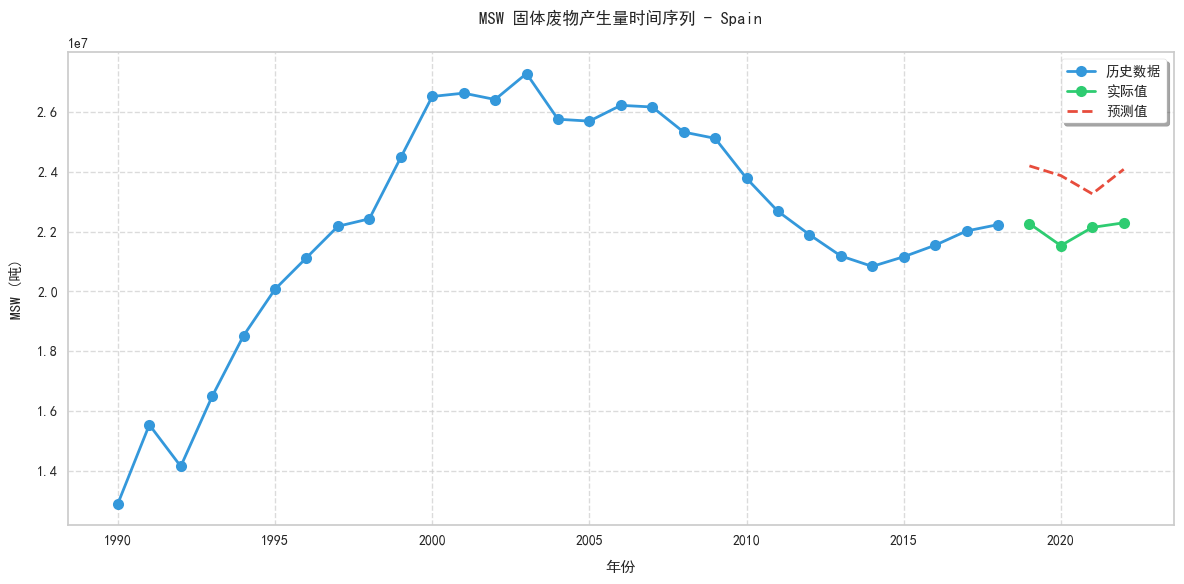

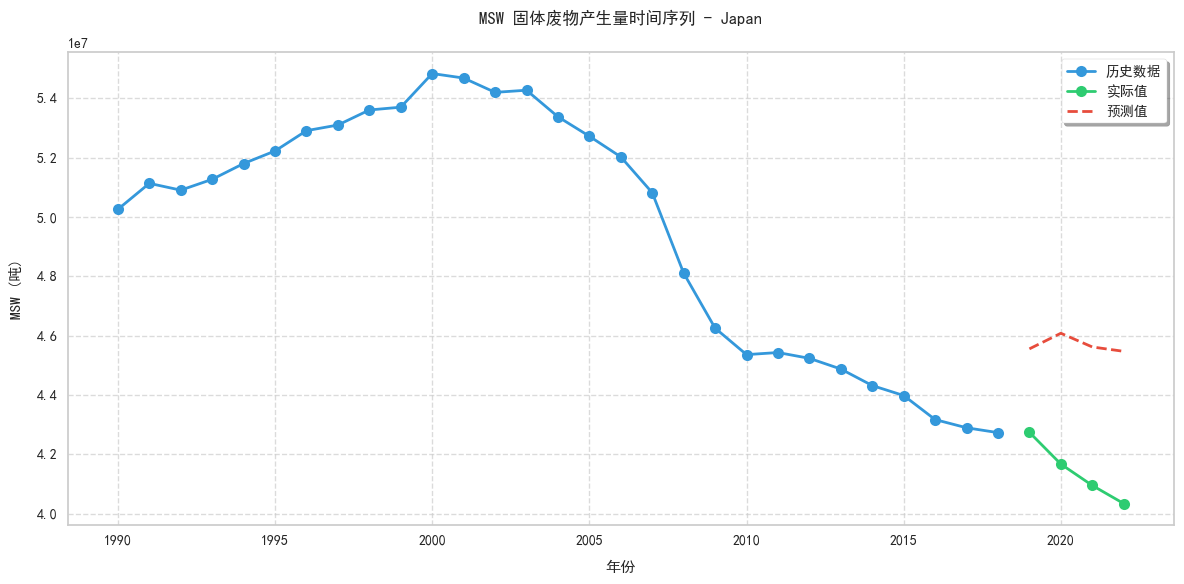

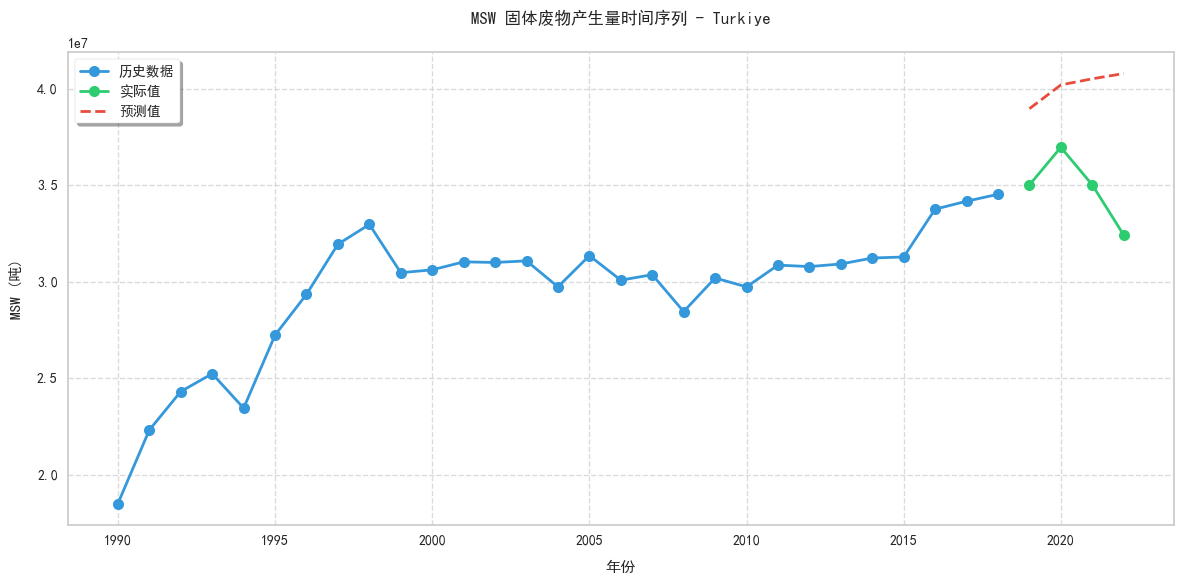

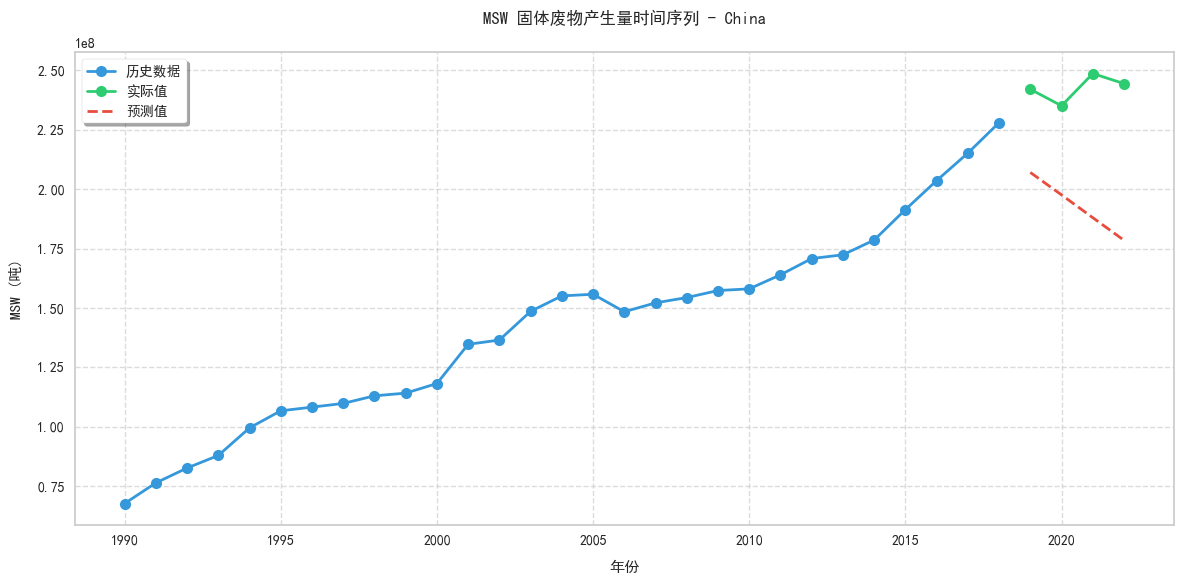

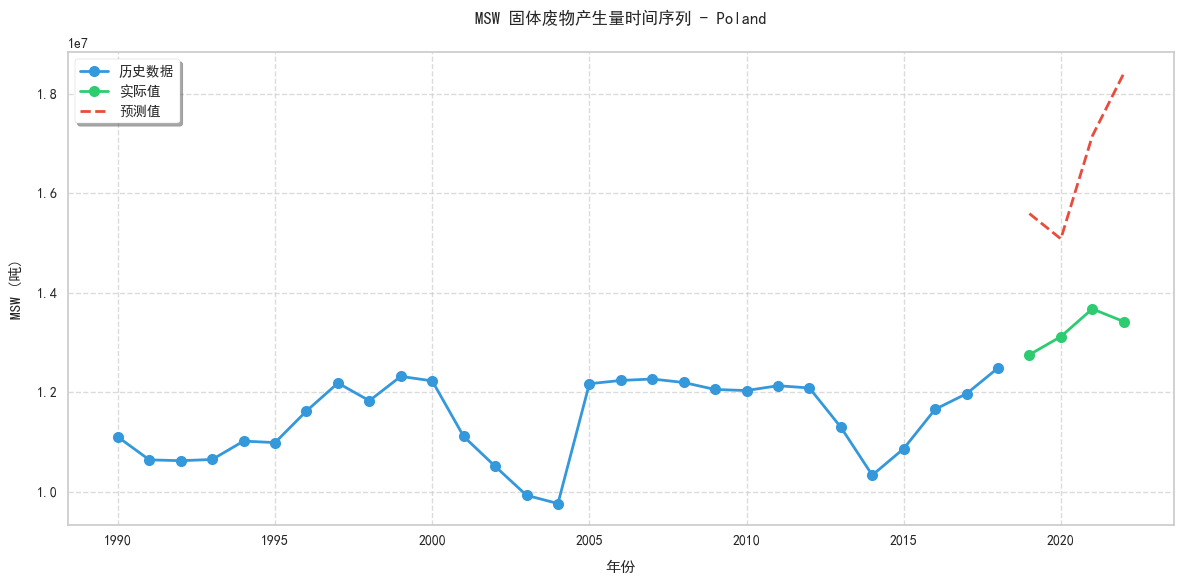

In [7]:
visualizer.plot_all_country_predictions(country_results)
visualizer.plot_top_time_predictions(train_data,time_results)